In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.special import expit
import pickle
import csv
import copy
import itertools
from lightfm import LightFM
import lightfm.evaluation
import sys
sys.path.append('../')
import helpers

In [2]:
df = pd.read_csv('data/model_likes_anon.psv',
                 sep='|', quoting=csv.QUOTE_MINIMAL,
                 quotechar='\\')
df.drop_duplicates(inplace=True)
df.head()

,modelname,mid,uid
0,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,7ac1b40648fff523d7220a5d07b04d9b
1,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,2b4ad286afe3369d39f1bb7aa2528bc7
2,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,1bf0993ebab175a896ac8003bed91b4b
3,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,6484211de8b9a023a7d9ab1641d22e7c
4,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,1109ee298494fbd192e27878432c718a


In [3]:
# Threshold data to only include users and models with min 5 likes.
df = helpers.threshold_interactions_df(df, 'uid', 'mid', 5, 5)

Starting interactions info
Number of rows: 62583
Number of cols: 28806
Sparsity: 0.035%
Ending interactions info
Number of rows: 15274
Number of columns: 25655
Sparsity: 0.140%


In [4]:
# Go from dataframe to likes matrix
# Also, build index to ID mappers.
likes, uid_to_idx, idx_to_uid,\
mid_to_idx, idx_to_mid = helpers.df_to_matrix(df, 'uid', 'mid')

likes

<15274x25655 sparse matrix of type '<class 'numpy.float64'>'
	with 547477 stored elements in Compressed Sparse Row format>

In [5]:
train, test, user_index = helpers.train_test_split(likes, 5, fraction=0.2)

#### The one odd thing that we must do which is different than last time is to copy the training data to only include users with data in the test set. This is due to using LightFM’s built-in precision_at_k function as opposed to our hand-rolled one last time and is not particularly interesting.

In [6]:
eval_train = train.copy()
non_eval_users = list(set(range(train.shape[0])) - set(user_index))

eval_train = eval_train.tolil()
for u in non_eval_users:
    eval_train[u, :] = 0.0
eval_train = eval_train.tocsr()

Now we want to one-hot-encode all of the side information that we have about the Sketchfab models. Recall that this information included categories and tags associated with each model. The simplest way I’ve found to go about encoding this information is to use scikit-learn’s DictVectorizer class. The DictVectorizer takes in a list of dictionaries where the dictionaries contain features names as keys and weights as values. Here, we’ll assume that each weight is 1, and we’ll take the key to be the combination of the tag type and value.

In [7]:
sideinfo = pd.read_csv('data/model_feats.psv',
                       sep='|', quoting=csv.QUOTE_MINIMAL,
                       quotechar='\\')
sideinfo.head()

,mid,type,value
0,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,category,Characters
1,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,category,Gaming
2,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,tag,3dsmax
3,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,tag,noel
4,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,tag,loli


In [8]:
# There's probably a fancy pandas groupby way to do
# this but I couldn't figure it out :(

# Build list of dictionaries containing features 
# and weights in same order as idx_to_mid prescribes.
feat_dlist = [{} for _ in idx_to_mid]
for idx, row in sideinfo.iterrows():
    feat_key = '{}_{}'.format(row.type, str(row.value).lower())
    idx = mid_to_idx.get(row.mid)
    if idx is not None:
        feat_dlist[idx][feat_key] = 1

In [9]:
feat_dlist[0]

{'category_characters': 1,
 'category_gaming': 1,
 'tag_3dsmax': 1,
 'tag_noel': 1,
 'tag_loli': 1,
 'tag_anime': 1,
 'tag_girl': 1,
 'tag_3d': 1,
 'tag_3dcellshade': 1,
 'tag_soranomethod': 1}

In [10]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer()
item_features = dv.fit_transform(feat_dlist)
item_features

<25655x20352 sparse matrix of type '<class 'numpy.float64'>'
	with 161510 stored elements in Compressed Sparse Row format>

We are now left with an item_features matrix where each row is a unique item (in the same order as the columns of the likes matrix), and each column is a unique tag. It looks like there are 20352 unique tags!

In [11]:
def print_log(row, header=False, spacing=12):
    top = ''
    middle = ''
    bottom = ''
    for r in row:
        top += '+{}'.format('-'*spacing)
        if isinstance(r, str):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, int):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif (isinstance(r, float)
              or isinstance(r, np.float32)
              or isinstance(r, np.float64)):
            middle += '| {0:^{1}.5f} '.format(r, spacing-2)
        bottom += '+{}'.format('='*spacing)
    top += '+'
    middle += '|'
    bottom += '+'
    if header:
        print(top)
        print(middle)
        print(bottom)
    else:
        print(middle)
        print(top)

def patk_learning_curve(model, train, test, eval_train,
                        iterarray, user_features=None,
                        item_features=None, k=5,
                        **fit_params):
    old_epoch = 0
    train_patk = []
    test_patk = []
    headers = ['Epoch', 'train p@5', 'test p@5']
    print_log(headers, header=True)
    for epoch in iterarray:
        more = epoch - old_epoch
        model.fit_partial(train, user_features=user_features,
                          item_features=item_features,
                          epochs=more, **fit_params)
        this_test = lightfm.evaluation.precision_at_k(model, test, train_interactions=None, k=k)
        this_train = lightfm.evaluation.precision_at_k(model, eval_train, train_interactions=None, k=k)

        train_patk.append(np.mean(this_train))
        test_patk.append(np.mean(this_test))
        row = [epoch, train_patk[-1], test_patk[-1]]
        print_log(row)
    return model, train_patk, test_patk

In [12]:
model = LightFM(loss='warp', random_state=2016)
# Initialize model.
model.fit(train, epochs=0);

iterarray = range(10, 110, 10)

model, train_patk, test_patk = patk_learning_curve(
    model, train, test, eval_train, iterarray, k=5, **{'num_threads': 4}
)

+------------+------------+------------+
|   Epoch    | train p@5  |  test p@5  |
+============+============+============+
|     10     |  0.14872   |  0.02639   |
+------------+------------+------------+
|     20     |  0.16961   |  0.02888   |
+------------+------------+------------+
|     30     |  0.17741   |  0.03058   |
+------------+------------+------------+
|     40     |  0.18251   |  0.03137   |
+------------+------------+------------+
|     50     |  0.18402   |  0.03104   |
+------------+------------+------------+
|     60     |  0.18389   |  0.03248   |
+------------+------------+------------+
|     70     |  0.18468   |  0.03163   |
+------------+------------+------------+
|     80     |  0.18546   |  0.03235   |
+------------+------------+------------+
|     90     |  0.18500   |  0.03229   |
+------------+------------+------------+
|    100     |  0.18415   |  0.03222   |
+------------+------------+------------+


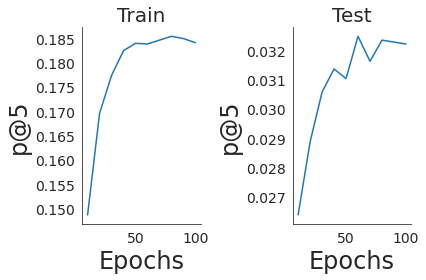

In [13]:
import seaborn as sns
sns.set_style('white')

def plot_patk(iterarray, patk,
              title, k=5):
    plt.plot(iterarray, patk);
    plt.title(title, fontsize=20);
    plt.xlabel('Epochs', fontsize=24);
    plt.ylabel('p@{}'.format(k), fontsize=24);
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);

# Plot train on left
ax = plt.subplot(1, 2, 1)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, train_patk,
         'Train', k=5)

# Plot test on right
ax = plt.subplot(1, 2, 2)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, test_patk,
         'Test', k=5)

plt.tight_layout()

### Optimizing Hyperparameters with scikit-optimize

Now that we have a baseline, we would like to find optimal hyperparameters to maximize our p@k. On a side note, I’m not sure if precision at k is the best metric to be using here when all of our interactions are binary, but let’s just ignore that for now…

Last post I ran a grid search over a bunch of hyperparameters, and it took forever. It’s been shown that a randomized search is better than explicit grid search, but we can do even better. Using the scikit-optimize (skopt) library, we can treat the hyperpameters as free parameters to search over while using a black box optimization algorithm to maximize p@k. There are a number of optimization algorithms to pick from, but I’ll just stick with forest_minimize today.

The setup is pretty simple. You must first define an objective function that you want to minimize. The objective receives the parameters that you want to solve for as the arguments and returns the objective value at those parameters. Thus, for our case, we pass in the hyperparameters, we train the LightFM model with those parameters, and then return the p@k evaluated after training. Importantly, we must return the negative of the p@k because the objective must be minimized, so maximizing p@k is the same as minimizing the negative of the p@k. The last thing to note is that one must make liberal use of global variables because one can only pass hyperparameters to the objective function.

In [14]:
from skopt import forest_minimize

def objective(params):
    # unpack
    epochs, learning_rate,\
    no_components, alpha = params
    
    user_alpha = alpha
    item_alpha = alpha
    model = LightFM(loss='warp',
                    random_state=2016,
                    learning_rate=learning_rate,
                    no_components=no_components,
                    user_alpha=user_alpha,
                    item_alpha=item_alpha)
    model.fit(train, epochs=epochs,
              num_threads=4, verbose=True)
    
    patks = lightfm.evaluation.precision_at_k(model, test,
                                              train_interactions=None,
                                              k=5, num_threads=4)
    mapatk = np.mean(patks)
    # Make negative because we want to _minimize_ objective
    out = -mapatk
    # Handle some weird numerical shit going on
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out


With the objective function defined, we can define ranges for our hyperparameters. These can either be simple max and mins or we can assume a distribution like below. With the ranges defined, we simple call forest_minimize and wait a pretty long time.

In [15]:
space = [(1, 50), # epochs
         (10**-4, 1.0, 'log-uniform'), # learning_rate
         (20, 200), # no_components
         (10**-6, 10**-1, 'log-uniform'), # alpha
        ]

res_fm = forest_minimize(objective, space, n_calls=25,
                     random_state=0,
                     verbose=True)

print('Maximimum p@k found: {:6.5f}'.format(-res_fm.fun))
print('Optimal parameters:')
params = ['epochs', 'learning_rate', 'no_components', 'alpha']
for (p, x_) in zip(params, res_fm.x):
    print('{}: {}'.format(p, x_))


Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 1 started. Evaluating function at random point.


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 71.4043
Function value obtained: -0.0003
Current minimum: -0.0003
Iteration No: 2 started. Evaluating function at random point.


Epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 39.3718
Function value obtained: -0.0178
Current minimum: -0.0178
Iteration No: 3 started. Evaluating function at random point.


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 41.5809
Function value obtained: -0.0001
Current minimum: -0.0178
Iteration No: 4 started. Evaluating function at random point.


Epoch:   0%|          | 0/18 [00:00<?, ?it/s]

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 7.3075
Function value obtained: -0.0001
Current minimum: -0.0178
Iteration No: 5 started. Evaluating function at random point.


Epoch:   0%|          | 0/21 [00:00<?, ?it/s]

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 28.4184
Function value obtained: -0.0002
Current minimum: -0.0178
Iteration No: 6 started. Evaluating function at random point.


Epoch: 100%|██████████| 21/21 [00:36<00:00,  1.72s/it]


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 42.8844
Function value obtained: -0.0146
Current minimum: -0.0178
Iteration No: 7 started. Evaluating function at random point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 59.1960
Function value obtained: -0.0208
Current minimum: -0.0208
Iteration No: 8 started. Evaluating function at random point.


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 53.5560
Function value obtained: -0.0001
Current minimum: -0.0208
Iteration No: 9 started. Evaluating function at random point.


Epoch:   0%|          | 0/24 [00:00<?, ?it/s]

Iteration No: 9 ended. Evaluation done at random point.
Time taken: 11.2735
Function value obtained: -0.0211
Current minimum: -0.0211
Iteration No: 10 started. Evaluating function at random point.


Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 51.0319
Function value obtained: -0.0150
Current minimum: -0.0211
Iteration No: 11 started. Searching for the next optimal point.


Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 12.7221
Function value obtained: -0.0191
Current minimum: -0.0211
Iteration No: 12 started. Searching for the next optimal point.


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 8.4477
Function value obtained: -0.0244
Current minimum: -0.0244
Iteration No: 13 started. Searching for the next optimal point.


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 5.7464
Function value obtained: -0.0206
Current minimum: -0.0244
Iteration No: 14 started. Searching for the next optimal point.


Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 4.0540
Function value obtained: -0.0179
Current minimum: -0.0244
Iteration No: 15 started. Searching for the next optimal point.


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 9.6281
Function value obtained: -0.0001
Current minimum: -0.0244
Iteration No: 16 started. Searching for the next optimal point.


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 8.9392
Function value obtained: -0.0272
Current minimum: -0.0272
Iteration No: 17 started. Searching for the next optimal point.


Epoch:   0%|          | 0/11 [00:00<?, ?it/s]

Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 5.3035
Function value obtained: -0.0244
Current minimum: -0.0272
Iteration No: 18 started. Searching for the next optimal point.


Epoch:   0%|          | 0/9 [00:00<?, ?it/s]

Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 7.7580
Function value obtained: -0.0271
Current minimum: -0.0272
Iteration No: 19 started. Searching for the next optimal point.


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 8.0277
Function value obtained: -0.0291
Current minimum: -0.0291
Iteration No: 20 started. Searching for the next optimal point.


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 6.0515
Function value obtained: -0.0177
Current minimum: -0.0291
Iteration No: 21 started. Searching for the next optimal point.


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 7.2992
Function value obtained: -0.0172
Current minimum: -0.0291
Iteration No: 22 started. Searching for the next optimal point.


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 8.3102
Function value obtained: -0.0278
Current minimum: -0.0291
Iteration No: 23 started. Searching for the next optimal point.


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 8.3758
Function value obtained: -0.0262
Current minimum: -0.0291
Iteration No: 24 started. Searching for the next optimal point.


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 5.5103
Function value obtained: -0.0238
Current minimum: -0.0291
Iteration No: 25 started. Searching for the next optimal point.


Epoch: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 15.2856
Function value obtained: -0.0251
Current minimum: -0.0291
Maximimum p@k found: 0.02914
Optimal parameters:
epochs: 9
learning_rate: 0.06596674218765804
no_components: 29
alpha: 2.598656042270655e-05


No too shabby! We started with a p@k of ~0.034 with base hyperparameters, and then increased it to 0.0478 by finding better ones. Let’s see what happens if we add in our item features as side information to the matrix factorization model.

#### Learning to Rank + Side Information

LightFM makes certain subtle assumptions when you do or do not pass side information. When no user_features or item_features are explicitly included, then LightFM assumes that both feature matrices are in fact identity matrices of size (num_users X num_users) or (num_items X num_items) for user and item feature matrices, respectively. What this is effectively doing is one-hot-encoding each user and item ID as a single feature vector. In the case where you do pass an item_features matrix, then LightFM does not do any one-hot-encoding. Thus, each user and item ID does not get its own vector unless you explicitly define one. The easiest way to do this is to make your own identity matrix and stack it on the side of the item_features matrix that we already created. This way, each item is described by a single vector for its unique ID and then a set of vectors for each of its tags.

In [16]:
# Need to hstack item_features
eye = sp.eye(item_features.shape[0], item_features.shape[0]).tocsr()
item_features_concat = sp.hstack((eye, item_features))
item_features_concat = item_features_concat.tocsr().astype(np.float32)

In [17]:
def objective_wsideinfo(params):
    # unpack
    epochs, learning_rate,\
    no_components, item_alpha,\
    scale = params
    
    user_alpha = item_alpha * scale
    model = LightFM(loss='warp',
                    random_state=2016,
                    learning_rate=learning_rate,
                    no_components=no_components,
                    user_alpha=user_alpha,
                    item_alpha=item_alpha)
    model.fit(train, epochs=epochs,
              item_features=item_features_concat,
              num_threads=4, verbose=True)
    
    patks = lightfm.evaluation.precision_at_k(model, test,
                                              item_features=item_features_concat,
                                              train_interactions=None,
                                              k=5, num_threads=3)
    mapatk = np.mean(patks)
    # Make negative because we want to _minimize_ objective
    out = -mapatk
    # Weird shit going on
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out

With that defined, let’s now run a new hyperparameter search. I will add an extra scaling parameter which will control the scaling between the user and item item regularization (alpha) terms. Because of all of the extra item features, we may want to regularize things differently. We’ll also input an x0 term to forest_minimization which will allow us to start our hyperparameter search at the optimal parameters from the previous run without side information.

In [18]:
space = [(1, 50), # epochs
         (10**-3, 1.0, 'log-uniform'), # learning_rate
         (20, 200), # no_components
         (10**-5, 10**-3, 'log-uniform'), # item_alpha
         (0.001, 1., 'log-uniform') # user_scaling
        ]
x0 = res_fm.x.append(1.)
# This typecast is required
item_features = item_features.astype(np.float32)
res_fm_itemfeat = forest_minimize(objective_wsideinfo, space, n_calls=50,
                                  x0=x0,
                                  random_state=0,
                                  verbose=True)

Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 1 started. Evaluating function at random point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 286.4760
Function value obtained: -0.0002
Current minimum: -0.0002
Iteration No: 2 started. Evaluating function at random point.


Epoch:   0%|          | 0/13 [00:00<?, ?it/s]

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 69.6870
Function value obtained: -0.0008
Current minimum: -0.0008
Iteration No: 3 started. Evaluating function at random point.


Epoch:   0%|          | 0/38 [00:00<?, ?it/s]

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 54.4737
Function value obtained: -0.0326
Current minimum: -0.0326
Iteration No: 4 started. Evaluating function at random point.


Epoch: 100%|██████████| 38/38 [03:46<00:00,  5.97s/it]


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 246.1396
Function value obtained: -0.0002
Current minimum: -0.0326
Iteration No: 5 started. Evaluating function at random point.


Epoch: 100%|██████████| 6/6 [01:13<00:00, 12.19s/it]


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 107.4744
Function value obtained: -0.0000
Current minimum: -0.0326
Iteration No: 6 started. Evaluating function at random point.


Epoch: 100%|██████████| 50/50 [05:18<00:00,  6.36s/it]


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 357.6540
Function value obtained: -0.0428
Current minimum: -0.0428
Iteration No: 7 started. Evaluating function at random point.


Epoch: 100%|██████████| 2/2 [00:18<00:00,  9.03s/it]


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 52.5972
Function value obtained: -0.0052
Current minimum: -0.0428
Iteration No: 8 started. Evaluating function at random point.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 186.6522
Function value obtained: -0.0305
Current minimum: -0.0428
Iteration No: 9 started. Evaluating function at random point.


Epoch:   0%|          | 0/16 [00:00<?, ?it/s]

Iteration No: 9 ended. Evaluation done at random point.
Time taken: 34.1561
Function value obtained: -0.0127
Current minimum: -0.0428
Iteration No: 10 started. Evaluating function at random point.


Epoch:   0%|          | 0/34 [00:00<?, ?it/s]

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 79.8961
Function value obtained: -0.0001
Current minimum: -0.0428
Iteration No: 11 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 197.0388
Function value obtained: -0.0417
Current minimum: -0.0428
Iteration No: 12 started. Searching for the next optimal point.


Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 251.3841
Function value obtained: -0.0422
Current minimum: -0.0428
Iteration No: 13 started. Searching for the next optimal point.


Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 251.9890
Function value obtained: -0.0282
Current minimum: -0.0428
Iteration No: 14 started. Searching for the next optimal point.


Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 221.4917
Function value obtained: -0.0448
Current minimum: -0.0448
Iteration No: 15 started. Searching for the next optimal point.


Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 106.9876
Function value obtained: -0.0415
Current minimum: -0.0448
Iteration No: 16 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 81.3328
Function value obtained: -0.0372
Current minimum: -0.0448
Iteration No: 17 started. Searching for the next optimal point.


Epoch:   0%|          | 0/43 [00:00<?, ?it/s]

Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 109.0219
Function value obtained: -0.0358
Current minimum: -0.0448
Iteration No: 18 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 146.8022
Function value obtained: -0.0421
Current minimum: -0.0448
Iteration No: 19 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 216.4172
Function value obtained: -0.0430
Current minimum: -0.0448
Iteration No: 20 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 170.8243
Function value obtained: -0.0433
Current minimum: -0.0448
Iteration No: 21 started. Searching for the next optimal point.


Epoch:   0%|          | 0/44 [00:00<?, ?it/s]

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 266.4647
Function value obtained: -0.0436
Current minimum: -0.0448
Iteration No: 22 started. Searching for the next optimal point.


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 174.1025
Function value obtained: -0.0416
Current minimum: -0.0448
Iteration No: 23 started. Searching for the next optimal point.


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 132.2120
Function value obtained: -0.0400
Current minimum: -0.0448
Iteration No: 24 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 163.9265
Function value obtained: -0.0285
Current minimum: -0.0448
Iteration No: 25 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 279.6382
Function value obtained: -0.0012
Current minimum: -0.0448
Iteration No: 26 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 308.3194
Function value obtained: -0.0412
Current minimum: -0.0448
Iteration No: 27 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 368.6493
Function value obtained: -0.0409
Current minimum: -0.0448
Iteration No: 28 started. Searching for the next optimal point.


Epoch:   0%|          | 0/33 [00:00<?, ?it/s]

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 83.5803
Function value obtained: -0.0206
Current minimum: -0.0448
Iteration No: 29 started. Searching for the next optimal point.


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 140.3675
Function value obtained: -0.0420
Current minimum: -0.0448
Iteration No: 30 started. Searching for the next optimal point.


Epoch:   0%|          | 0/31 [00:00<?, ?it/s]

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 99.4665
Function value obtained: -0.0409
Current minimum: -0.0448
Iteration No: 31 started. Searching for the next optimal point.


Epoch:   0%|          | 0/49 [00:00<?, ?it/s]

Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 103.5096
Function value obtained: -0.0370
Current minimum: -0.0448
Iteration No: 32 started. Searching for the next optimal point.


Epoch:   0%|          | 0/41 [00:00<?, ?it/s]

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 309.0882
Function value obtained: -0.0311
Current minimum: -0.0448
Iteration No: 33 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 197.8922
Function value obtained: -0.0331
Current minimum: -0.0448
Iteration No: 34 started. Searching for the next optimal point.


Epoch:   0%|          | 0/35 [00:00<?, ?it/s]

Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 62.9769
Function value obtained: -0.0363
Current minimum: -0.0448
Iteration No: 35 started. Searching for the next optimal point.


Epoch:   0%|          | 0/28 [00:00<?, ?it/s]

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 127.6138
Function value obtained: -0.0240
Current minimum: -0.0448
Iteration No: 36 started. Searching for the next optimal point.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 141.2937
Function value obtained: -0.0407
Current minimum: -0.0448
Iteration No: 37 started. Searching for the next optimal point.


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 116.3303
Function value obtained: -0.0394
Current minimum: -0.0448
Iteration No: 38 started. Searching for the next optimal point.


Epoch:   0%|          | 0/19 [00:00<?, ?it/s]

Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 392.2928
Function value obtained: -0.0299
Current minimum: -0.0448
Iteration No: 39 started. Searching for the next optimal point.


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 75.5612
Function value obtained: -0.0395
Current minimum: -0.0448
Iteration No: 40 started. Searching for the next optimal point.


Epoch:   0%|          | 0/21 [00:00<?, ?it/s]

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 89.9277
Function value obtained: -0.0380
Current minimum: -0.0448
Iteration No: 41 started. Searching for the next optimal point.


Epoch:   0%|          | 0/9 [00:00<?, ?it/s]

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 58.3284
Function value obtained: -0.0377
Current minimum: -0.0448
Iteration No: 42 started. Searching for the next optimal point.


Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 57.9160
Function value obtained: -0.0335
Current minimum: -0.0448
Iteration No: 43 started. Searching for the next optimal point.


Epoch:   0%|          | 0/17 [00:00<?, ?it/s]

Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 204.7170
Function value obtained: -0.0464
Current minimum: -0.0464
Iteration No: 44 started. Searching for the next optimal point.


Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 114.5038
Function value obtained: -0.0348
Current minimum: -0.0464
Iteration No: 45 started. Searching for the next optimal point.


Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 215.2605
Function value obtained: -0.0009
Current minimum: -0.0464
Iteration No: 46 started. Searching for the next optimal point.


Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 226.2605
Function value obtained: -0.0422
Current minimum: -0.0464
Iteration No: 47 started. Searching for the next optimal point.


Epoch:   0%|          | 0/48 [00:00<?, ?it/s]

Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 167.5966
Function value obtained: -0.0446
Current minimum: -0.0464
Iteration No: 48 started. Searching for the next optimal point.


Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 230.9554
Function value obtained: -0.0461
Current minimum: -0.0464
Iteration No: 49 started. Searching for the next optimal point.


Epoch:   0%|          | 0/45 [00:00<?, ?it/s]

Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 207.3272
Function value obtained: -0.0350
Current minimum: -0.0464
Iteration No: 50 started. Searching for the next optimal point.


Epoch: 100%|██████████| 45/45 [04:13<00:00,  5.62s/it]


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 277.3724
Function value obtained: -0.0134
Current minimum: -0.0464


In [19]:
print('Maximimum p@k found: {:6.5f}'.format(-res_fm_itemfeat.fun))
print('Optimal parameters:')
params = ['epochs', 'learning_rate', 'no_components', 'item_alpha', 'scaling']
for (p, x_) in zip(params, res_fm_itemfeat.x):
    print('{}: {}'.format(p, x_))

Maximimum p@k found: 0.04643
Optimal parameters:
epochs: 48
learning_rate: 0.030323230179467645
no_components: 103
item_alpha: 0.0004528762149522514
scaling: 0.6573302694284306


In all fairness, I only ran the above optimization for 50 calls, as opposed to the original one with 250 calls. This was mainly due to the matrix factorization model running much slower due to scaling with the number of user and item features.

Even so, there are other reasons that the results could be worse. Maybe user behavior is a much better signal than human-defined tags and categories. The tag information could be poor for some of the models. As well, one may need to scale the tags differently compared to the unique ID vectors using, say, separate regularization terms, in order to get better behavior. Maybe one should normalize the tag weights by the number of tags. Maybe tags should not be included unless they have been used on at least X models. Maybe tags should only be included on models with few user interactions because after that ponit the cold start problem is sufficiently null. Who knows?! These are experiments I’d love to run, but I’d be happy to hear from others’ experience.

#### Fun with Feature Embeddings

Regardless of all of this, there is still a benefit to incorporating the item features. Because they have vectors embedded in the same space as the users and items, we can play with different types of recommendations. We’ll first retrain the model on the full dataset using the optimal parameters.

In [20]:
epochs, learning_rate,\
no_components, item_alpha,\
scale = res_fm_itemfeat.x

user_alpha = item_alpha * scale
model = LightFM(loss='warp',
                random_state=2016,
                learning_rate=learning_rate,
                no_components=no_components,
                user_alpha=user_alpha,
                item_alpha=item_alpha)
model.fit(likes, epochs=epochs,
          item_features=item_features_concat,
          num_threads=4)

#### Feature Sorting

Imagine you’re on Sketchfab and click the tag tiltbrush which would presumably correspond to models created with Google’s Tilt Brush VR appliction. How should Sketchfab return the results to you? They currently return results based on the popularity of the items which is presumably not connected to the “tiltbrushiness” of the models. With the factorized tags, we can now return a list of products that are most similar to the tiltbrush tag sorted by that similarity. To do this, we must find the tiltbrush vector and measure the cosine similarity to every product.

Recall that we tacked our identity matrix onto the left-hand side of the item_features matrix. This means that our DictVectorizer, which mapped our item features to column indices of our item_features matrix, will have indices that are off by the number of items.

In [21]:
idx = dv.vocabulary_['tag_tiltbrush'] + item_features.shape[0]

Next, we need to calculate the cosine similarity between the tiltbrush vector and all other item representations where each item’s representation is the sum of its feature vectors. These feature vectors are stored as item_embeddings in the LightFM model. (Note: there are technically bias terms in the LightFM model that we are simply ignoring for now).

In [22]:
def cosine_similarity(vec, mat):
    sim = vec.dot(mat.T)
    matnorm = np.linalg.norm(mat, axis=1)
    vecnorm = np.linalg.norm(vec)
    return np.squeeze(sim / matnorm / vecnorm)

tilt_vec = model.item_embeddings[[idx], :]
item_representations = item_features_concat.dot(model.item_embeddings)
sims = cosine_similarity(tilt_vec, item_representations)

Lastly, we can repurpose some code from the last blog post to visualize the top 5 Sketchfab model thumbnails that are most similar to the tiltbrush vector.

In [23]:
import requests
def get_thumbnails(row, idx_to_mid, N=10):
    thumbs = []
    mids = []
    for x in np.argsort(-row)[:N]:
        response = requests.get('https://sketchfab.com/i/models/{}'\
                                .format(idx_to_mid[x])).json()
        thumb = [x['url'] for x in response['thumbnails']['images']
                 if x['width'] == 200 and x['height']==200]
        if not thumb:
            print('no thumbnail')
        else:
            thumb = thumb[0]
        thumbs.append(thumb)
        mids.append(idx_to_mid[x])
    return thumbs, mids



from IPython.display import display, HTML

def display_thumbs(thumbs, mids, N=5):
    thumb_html = "<a href='{}' target='_blank'>\
                  <img style='width: 160px; margin: 0px; \
                  border: 1px solid black;' \
                  src='{}' /></a>"
    images = ''
    for url, mid in zip(thumbs[0:N], mids[0:N]):
        link = 'http://sketchfab.com/models/{}'.format(mid)
        images += thumb_html.format(link, url)
    display(HTML(images))

display_thumbs(*get_thumbnails(sims, idx_to_mid))

no thumbnail


Pretty cool! Looks like each of these are made with Tiltbrush. Feel free to click the above images to check out each model on the Sketchfab website.

What else can we do?

#### Tag Suggestions

Let’s say that Sketchfab would like to encourage people to use more tags. This is advantageous to the company because it get users to create structured data for them for free while engaging the user. Sketchfab could encourage this behavior by suggesting tags to go with an image. One way we could do this would be to take a model and suggest tags to go with it that are not currently there. This involves finding tag vectors that are most similar to the model and then filtering tags that are already present.

In [41]:
idx = 900
mid = idx_to_mid[idx]
def display_single(mid):
    """Display thumbnail for a single model"""
    response = requests.get('https://sketchfab.com/i/models/{}'\
                            .format(mid)).json()
    for x in response['thumbnails']['images']:
        if x['width'] >= 200 and x['height']>=200:
            thumb = x["url"]
            thumb_html = "<a href='{}' target='_blank'>\
                          <img style='width: 200px; margin: 0px; \
                          border: 1px solid black;' \
                          src='{}' /></a>"
            link = 'http://sketchfab.com/models/{}'.format(mid)
            display(HTML(thumb_html.format(link, thumb)))
            break
display_single(mid)

In [28]:
# Make mapper to map from from feature index to feature name
idx_to_feat = {v: k for (k, v) in dv.vocabulary_.items()}
print('Tags:')
for i in item_features.getrow(idx).indices:
    print('- {}'.format(idx_to_feat[i]))
    
# Indices of all tag vectors
tag_indices = set(v for (k, v) in dv.vocabulary_.items()
                  if k.startswith('tag_'))
# Tags that are already present
filter_tags = set(i for i in item_features.getrow(idx).indices)

item_representation = item_features_concat[idx, :].dot(model.item_embeddings)
sims = cosine_similarity(item_representation, model.item_embeddings)

suggested_tags = []
i = 0
recs = np.argsort(-sims)
n_items = item_features.shape[0]
while len(suggested_tags) < 10:
    offset_idx = recs[i] - n_items
    if offset_idx in tag_indices\
       and offset_idx not in filter_tags:
        suggested_tags.append(idx_to_feat[offset_idx])
    i += 1
print('Suggested Tags:')
for t in suggested_tags:
    print('- {}'.format(t))

Tags:
- category_characters
- tag_3dsmaxpublisher
- tag_art
- tag_artstation
- tag_death
- tag_draenei
- tag_fan
- tag_knight
- tag_murkah
- tag_of
- tag_warcraft
- tag_world
Suggested Tags:
- tag_alyonushka
- tag_nightingale
- tag_characterbust
- tag_sibill
- tag_only
- tag_el
- tag_zeronis
- tag_castanic
- tag_musketeer
- tag_league


### References
https://www.ethanrosenthal.com/2016/11/07/implicit-mf-part-2/
https://github.com/benfred/implicit